# ECG Classification using the Clonal Selection Algorithm (CSA)
## Loading and Exploring the Dataset

In [1]:
# Preliminary imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Loading the dataset.
normal_heartbeat_dataset = pd.read_csv("data/ptbdb_normal.csv", header=None)
abnormal_heartbeat_dataset = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
heartbeat_dataset = pd.concat([normal_heartbeat_dataset, abnormal_heartbeat_dataset], ignore_index=True)

In [3]:
# Printing shapes of normal and abnormal heartbeat datasets. 
print(normal_heartbeat_dataset.shape)
print(abnormal_heartbeat_dataset.shape)
# Printing the shape of the combined dataset to ensure correct merging.
print(heartbeat_dataset.shape)

(4046, 188)
(10506, 188)
(14552, 188)


In [4]:
# Printing last columns of the dataset for ensuring correct labels.
print(normal_heartbeat_dataset.iloc[:, -1].unique())
print(abnormal_heartbeat_dataset.iloc[:, -1].unique())
print(heartbeat_dataset.iloc[:, -1].unique())

[0.]
[1.]
[0. 1.]


ECG Signal Type: Normal Heartbeat


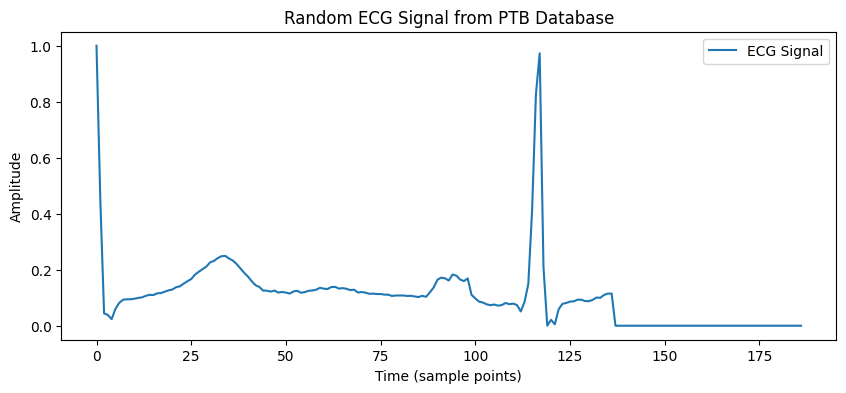

In [5]:
random_index = random.randint(1, 14552)

if heartbeat_dataset.iloc[random_index, -1] == 0:
    print("ECG Signal Type: Normal Heartbeat")
else:
    print("ECG Signal Type: Abnormal Heartbeat")

ecg_signal = heartbeat_dataset.iloc[random_index, :-1].values

plt.figure(figsize=(10, 4))
plt.plot(ecg_signal, label="ECG Signal")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude")
plt.title("Random ECG Signal from PTB Database")
plt.legend()
plt.show()

## Generating Training and Testing Data

In [6]:
def retrieve_abnormal_heartbeat_data():
    return abnormal_heartbeat_dataset.sample(n=500)

In [7]:
def retrieve_normal_heartbeat_data():
    normal_heartbeat_values = normal_heartbeat_dataset.sample(n=4000)
    training_data = normal_heartbeat_values.iloc[:3500]
    normal_testing_data = normal_heartbeat_values.iloc[3500:]
    return training_data, normal_testing_data

In [8]:
def generate_training_and_testing_dataset():
    training_data, normal_testing_data = retrieve_normal_heartbeat_data()
    abnormal_testing_data = retrieve_abnormal_heartbeat_data()
    testing_data = pd.concat([normal_testing_data, abnormal_testing_data], ignore_index=True)
    return training_data, testing_data

In [9]:
training_data, testing_data = generate_training_and_testing_dataset()

In [10]:
training_data.shape

(3500, 188)

In [11]:
testing_data.shape

(1000, 188)

In [12]:
print(training_data.iloc[:, -1].unique())

[0.]


In [13]:
print(testing_data.iloc[:, -1].unique())

[0. 1.]


## Generating Antibodies

In [14]:
def generate_antibody():
    return [random.uniform(0, 1) for _ in range(187)]

In [15]:
def generate_population(quant=100):
    population = []
    for i in range(quant):
        population.append(generate_antibody())
    return population

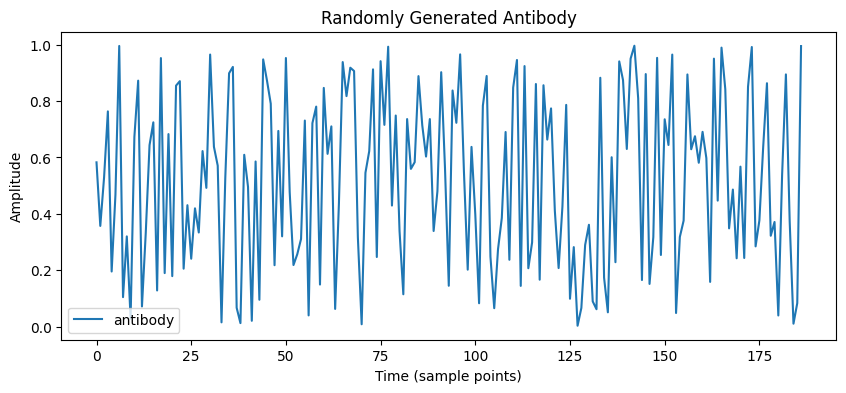

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(generate_antibody(), label='antibody')
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude")
plt.title("Randomly Generated Antibody")
plt.legend()
plt.show()

## Defining the Fitness Function (Affinity)

### Affinity function considering only the first 50 time samples

In [17]:
def affinity(antibody, antigen):
    manhattan_distance = 0
    for index in range(50):
        difference = antibody[index]-antigen[index]
        if difference < 0:
            difference = -difference
        manhattan_distance += difference
    return manhattan_distance

### Affinity function considering only the first 75 time samples

In [18]:
def affinity_two(antibody, antigen):
    manhattan_distance = 0
    for index in range(75):
        difference = antibody[index]-antigen[index]
        if difference < 0:
            difference = -difference
        manhattan_distance += difference
    return manhattan_distance

### Affinity function considering only the first 100 time samples

In [19]:
def affinity_three(antibody, antigen):
    manhattan_distance = 0
    for index in range(100):
        difference = antibody[index]-antigen[index]
        if difference < 0:
            difference = -difference
        manhattan_distance += difference
    return manhattan_distance

In [20]:
def affinity_antibodies(population, antigens):
    population_affinities = [0 for _ in population]
    for index in range(len(population)):
        for antigen in antigens:
            population_affinities[index] += affinity(population[index], antigen)
    return population_affinities

In [21]:
def affinity_antibodies_two(population, antigens):
    population_affinities = [0 for _ in population]
    for index in range(len(population)):
        for antigen in antigens:
            population_affinities[index] += affinity_two(population[index], antigen)
    return population_affinities

In [22]:
def affinity_antibodies_three(population, antigens):
    population_affinities = [0 for _ in population]
    for index in range(len(population)):
        for antigen in antigens:
            population_affinities[index] += affinity_three(population[index], antigen)
    return population_affinities

## Initial CSA Algorithm Value Generator Functions Based on the Affinity Metric Being Used

In [23]:
def generate_initial_CSA_values():
    training_data, testing_data = generate_training_and_testing_dataset()
    population = generate_population()
    population_affinities = affinity_antibodies(population, training_data.values.tolist())
    return training_data, testing_data, population, population_affinities

In [24]:
def generate_initial_CSA_values_two():
    training_data, testing_data = generate_training_and_testing_dataset()
    population = generate_population()
    population_affinities = affinity_antibodies_two(population, training_data.values.tolist())
    return training_data, testing_data, population, population_affinities

In [25]:
def generate_initial_CSA_values_three():
    training_data, testing_data = generate_training_and_testing_dataset()
    population = generate_population()
    population_affinities = affinity_antibodies_three(population, training_data.values.tolist())
    return training_data, testing_data, population, population_affinities

## Selection of N-best antibodies

In [26]:
def n_best(population, population_affinities, n=10):
    sorted_indices = sorted(range(len(population_affinities)), key=lambda i: population_affinities[i])
    smallest_n_indices = sorted_indices[:n]
    n_best_affinities = [population_affinities[i] for i in smallest_n_indices]
    n_best_antibodies = [population[i] for i in smallest_n_indices]
    return n_best_antibodies, n_best_affinities

In [27]:
training_data, testing_data, population, population_affinities = generate_initial_CSA_values()
n_best_antibodies, n_best_affinities = n_best(population, population_affinities)

## Cloning the N-best antibodies

In [28]:
cloning_factor = 90

In [29]:
def clone(cloning_factor, n_best_antibodies, n_best_affinities):
    clones = []
    affinities = []
    affinity_sum = sum(n_best_affinities)
    cloning_frequencies = [round((affinity/affinity_sum) * cloning_factor) for affinity in n_best_affinities]
    for index in range(len(cloning_frequencies)):
        for i in range(cloning_frequencies[index]):
            clones.append(n_best_antibodies[index])
            affinities.append(n_best_affinities[index])
    clones = n_best_antibodies + clones
    affinities = n_best_affinities + affinities
    while len(clones) < 100:
        clones.append(clones[-1])
        affinities.append(affinities[-1])
    return clones, affinities

In [30]:
training_data, testing_data, population, population_affinities = generate_initial_CSA_values()
n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

## Hypermutation of antibodies

In [31]:
def mutate_value(value):
    random_mutation = random.uniform(-value, 1-value)
    return value + random_mutation

### Hypermutation functions based on using the three different affinity metrics

In [32]:
def hypermutate(hypermutation_factor, clones):
    hypermutated_clones = []
    max_affinity = len(training_data) * 50
    for clone in clones:
        affinity = affinity_antibodies([clone], training_data.values.tolist())[0]
        hypRate = (1 - (affinity/max_affinity)) * hypermutation_factor
        hypermutated_clone = []
        for value in clone:
            random_number = random.random()
            if random_number <= hypRate:
                hypermutated_clone.append(mutate_value(value))
            else:
                hypermutated_clone.append(value)
        hypermutated_clones.append(hypermutated_clone)
    return hypermutated_clones

In [33]:
def hypermutate_two(hypermutation_factor, clones):
    hypermutated_clones = []
    max_affinity = len(training_data) * 50
    for clone in clones:
        affinity = affinity_antibodies_two([clone], training_data.values.tolist())[0]
        hypRate = (1 - (affinity/max_affinity)) * hypermutation_factor
        hypermutated_clone = []
        for value in clone:
            random_number = random.random()
            if random_number <= hypRate:
                hypermutated_clone.append(mutate_value(value))
            else:
                hypermutated_clone.append(value)
        hypermutated_clones.append(hypermutated_clone)
    return hypermutated_clones

In [34]:
def hypermutate_three(hypermutation_factor, clones):
    hypermutated_clones = []
    max_affinity = len(training_data) * 50
    for clone in clones:
        affinity = affinity_antibodies_three([clone], training_data.values.tolist())[0]
        hypRate = (1 - (affinity/max_affinity)) * hypermutation_factor
        hypermutated_clone = []
        for value in clone:
            random_number = random.random()
            if random_number <= hypRate:
                hypermutated_clone.append(mutate_value(value))
            else:
                hypermutated_clone.append(value)
        hypermutated_clones.append(hypermutated_clone)
    return hypermutated_clones

### Code to Initialize and Hypermutate the Antibodies Once - Used Further in the complete CSA functions

In [35]:
training_data, testing_data, population, population_affinities = generate_initial_CSA_values()
n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)
hypermutated_clones = hypermutate(0.1, clones)
hypermutated_affinities = affinity_antibodies(hypermutated_clones, training_data.values.tolist())

In [36]:
training_data, testing_data, population, population_affinities = generate_initial_CSA_values()
n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

### Exploration of the Combined Affinity Values After Training the CSA Algorithm for 10 Iterations

In [37]:
for i in range(10):
    hypermutated_clones = hypermutate(0.1, clones)
    hypermutated_affinities = affinity_antibodies(hypermutated_clones, training_data.values.tolist())
    print(min(hypermutated_affinities))
    n_best_antibodies, n_best_affinities = n_best(hypermutated_clones, hypermutated_affinities)
    clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

45741.54248713159
43084.17891111769
41141.24589274033
37945.028371210334
37273.35407777625
36517.87045851052
34507.52319896384
33590.57870546537
33111.842737797604
30735.81964045501


In [38]:
testing_list = testing_data.values.tolist()

In [39]:
testing_affinities = []
for antigen in testing_list:
    testing_affinities.append(affinity(clones[0], antigen))

In [40]:
sorted_testing_indices = sorted(range(len(testing_affinities)), key=lambda i: testing_affinities[i])
sorted_testing_affinities = [testing_affinities[i] for i in sorted_testing_indices]
sorted_testing_list = [testing_list[i] for i in sorted_testing_indices]

## Calculating metrics for binary classification of normal and abnormal heartbeats in the testing dataset

In [41]:
true_labels = [ecg_data[-1] for ecg_data in sorted_testing_list]
predicted_labels = [0] * 500 + [1] * 500
random_predicted_labels = [random.randint(0, 1) for _ in sorted_testing_list]

In [42]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')

In [43]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.6260
Precision: 0.6260
Recall: 0.6260
F1-score: 0.6260


In [44]:
accuracy = accuracy_score(true_labels, random_predicted_labels)
precision = precision_score(true_labels, random_predicted_labels, average='binary')
recall = recall_score(true_labels, random_predicted_labels, average='binary')
f1 = f1_score(true_labels, random_predicted_labels, average='binary')

In [45]:
print(f'Accuracy with random guess: {accuracy:.4f}')
print(f'Precision with random guess: {precision:.4f}')
print(f'Recall with random guess: {recall:.4f}')
print(f'F1-score with random guess: {f1:.4f}')

Accuracy with random guess: 0.5210
Precision with random guess: 0.5205
Recall with random guess: 0.5320
F1-score with random guess: 0.5262


## Combining Steps for Visualizations of Metrics

In [46]:
def calculate_metrics(testing_data, clones):
    testing_list = testing_data.values.tolist()
    testing_affinities = []
    
    for antigen in testing_list:
        testing_affinities.append(affinity(clones[0], antigen))
    
    sorted_testing_indices = sorted(range(len(testing_affinities)), key=lambda i: testing_affinities[i])
    sorted_testing_affinities = [testing_affinities[i] for i in sorted_testing_indices]
    sorted_testing_list = [testing_list[i] for i in sorted_testing_indices]
    
    true_labels = [ecg_data[-1] for ecg_data in sorted_testing_list]
    predicted_labels = [0] * 500 + [1] * 500

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')
    
    return accuracy, precision, recall, f1

In [47]:
def CSA_for_ECG_classification(iterations = 100, hypermutation_factor=0.1):
    training_data, testing_data, population, population_affinities = generate_initial_CSA_values()
    n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
    clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

    accuracies = []
    precisions = []
    recalls = []
    f_ones = []
    
    for i in range(iterations):
        hypermutated_clones = hypermutate(hypermutation_factor, clones)
        hypermutated_affinities = affinity_antibodies(hypermutated_clones, training_data.values.tolist())
        n_best_antibodies, n_best_affinities = n_best(hypermutated_clones, hypermutated_affinities)
        clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)
        
        accuracy, precision, recall, f1 = calculate_metrics(testing_data, clones)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f_ones.append(f1)

    iterations = list(range(1, len(accuracies) + 1))

    plt.figure(figsize=(10, 6))

    plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over 100 Iterations with Hypermutation Factor " + str(hypermutation_factor))

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("Maximum Accuracy Achieved: " + str(max(accuracies)))
    return max(accuracies)

## Final Results
## (Fitness Function only considers first 50 time samples)

In [48]:
max_accuracies = []

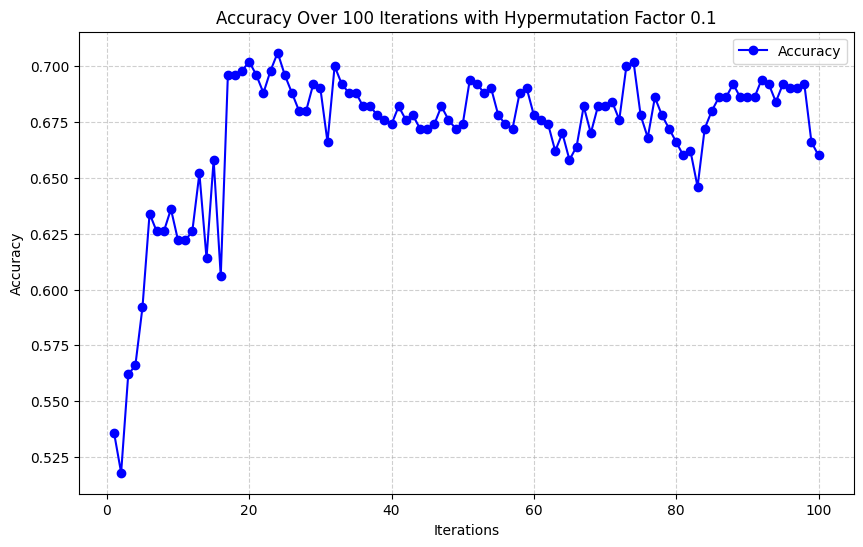

Maximum Accuracy Achieved: 0.706


In [49]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.1))

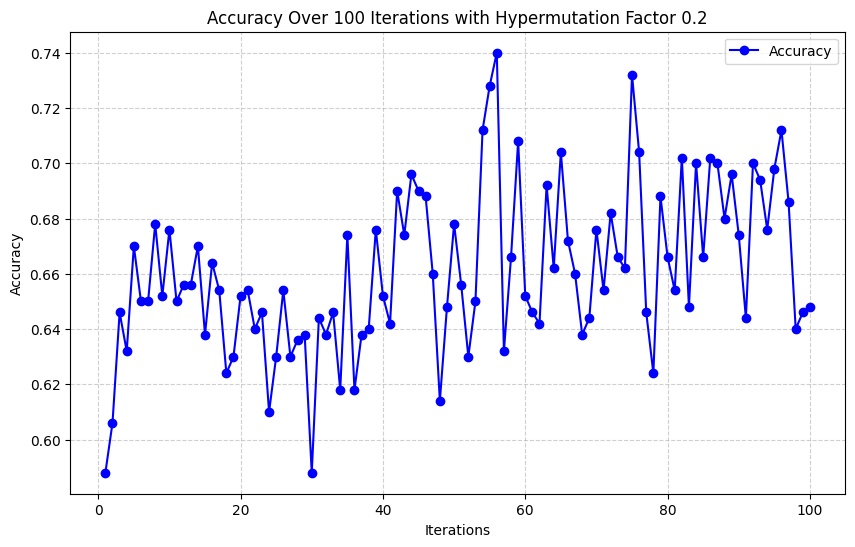

Maximum Accuracy Achieved: 0.74


In [50]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.2))

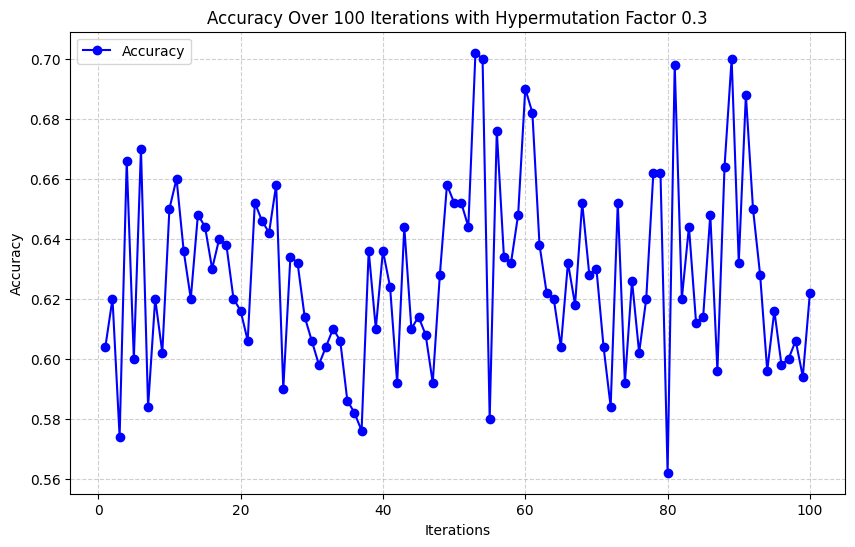

Maximum Accuracy Achieved: 0.702


In [51]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.3))

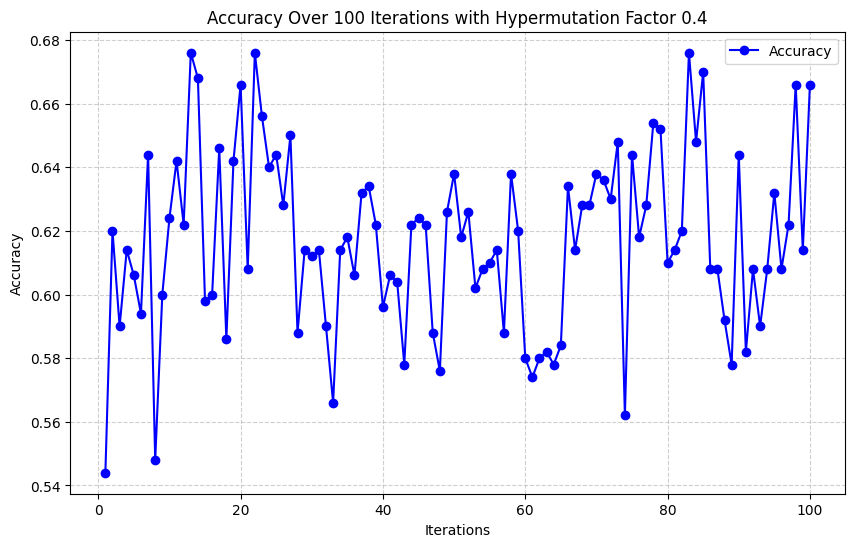

Maximum Accuracy Achieved: 0.676


In [52]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.4))

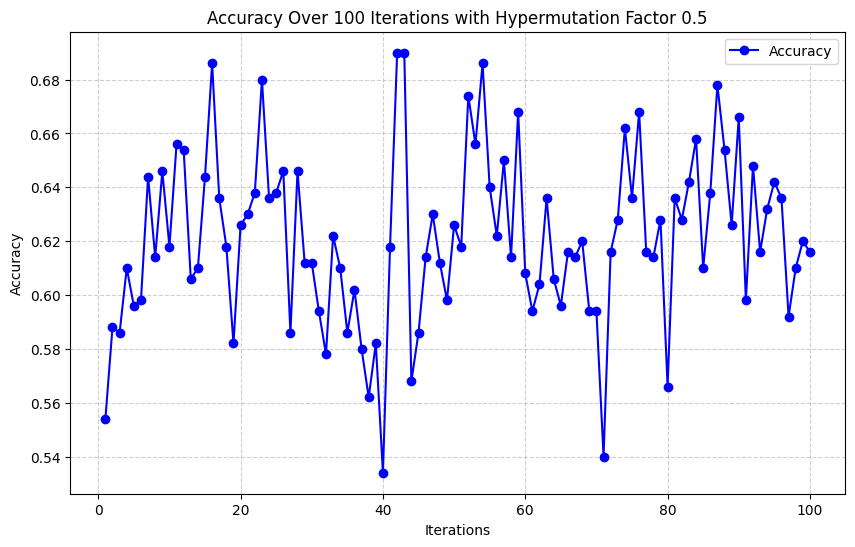

Maximum Accuracy Achieved: 0.69


In [53]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.5))

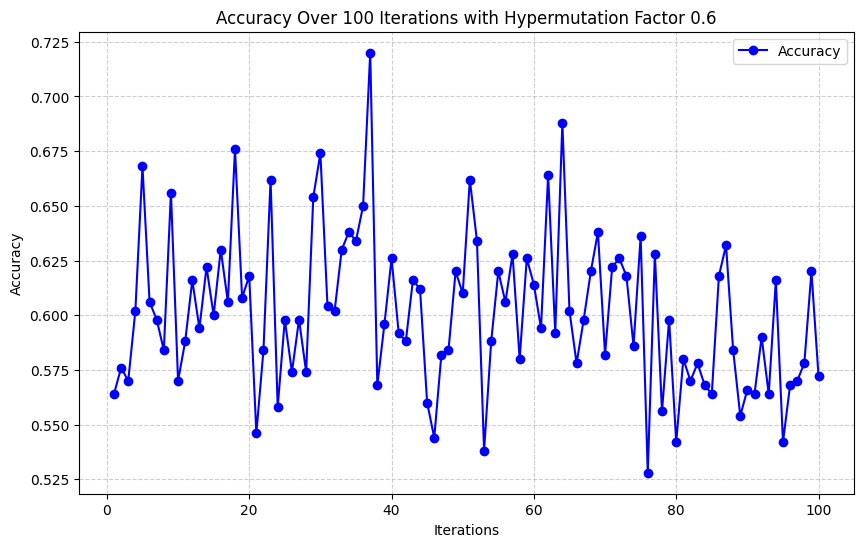

Maximum Accuracy Achieved: 0.72


In [54]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.6))

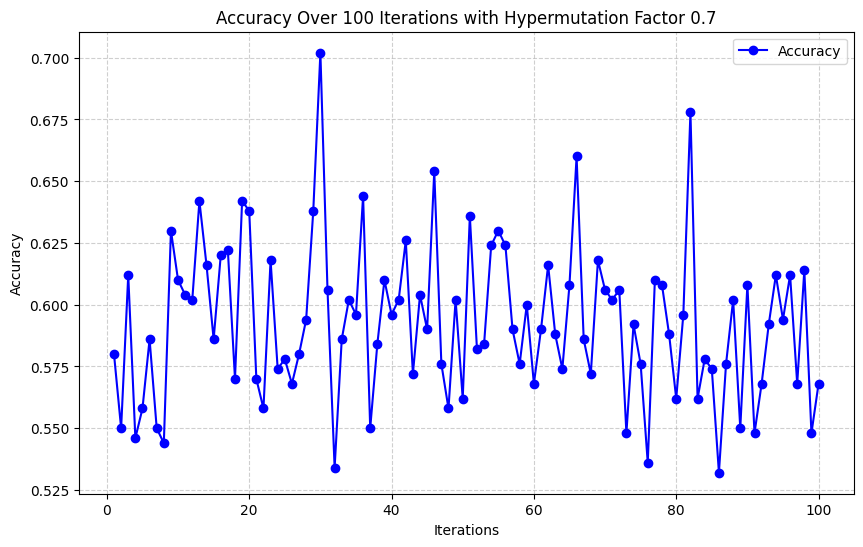

Maximum Accuracy Achieved: 0.702


In [55]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.7))

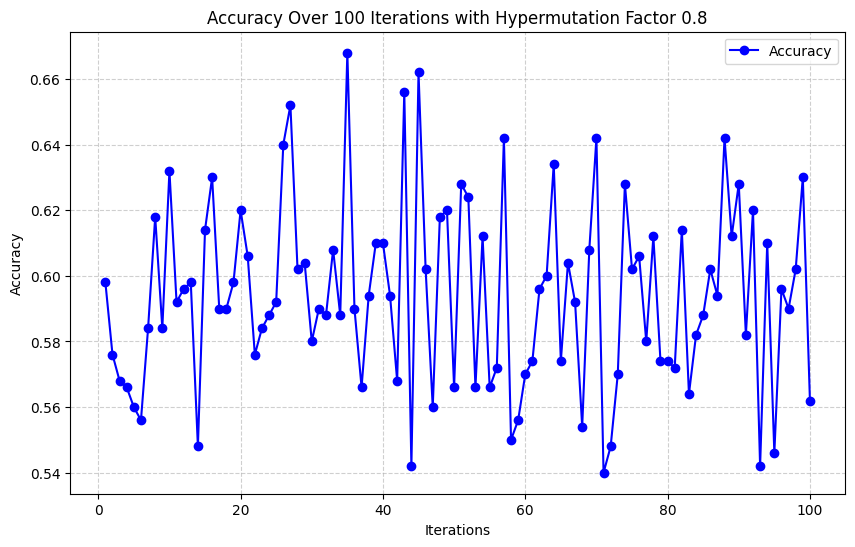

Maximum Accuracy Achieved: 0.668


In [56]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.8))

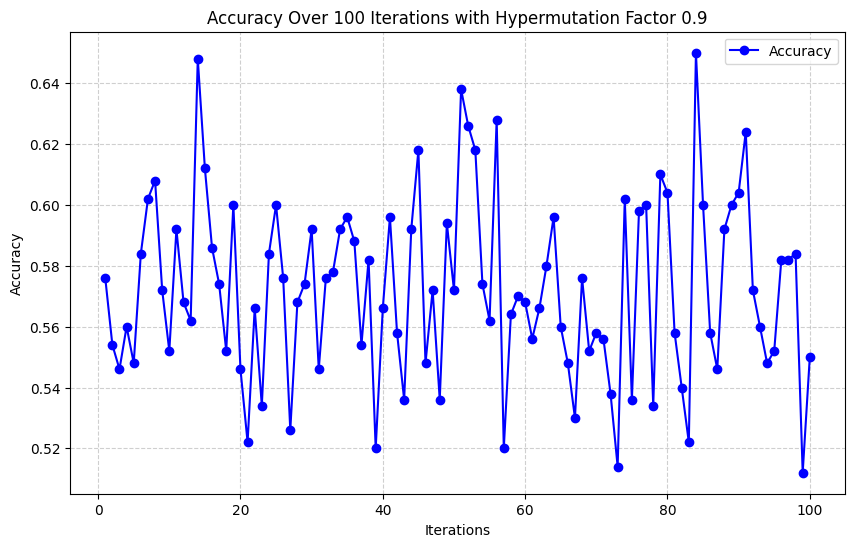

Maximum Accuracy Achieved: 0.65


In [57]:
max_accuracies.append(CSA_for_ECG_classification(hypermutation_factor=0.9))

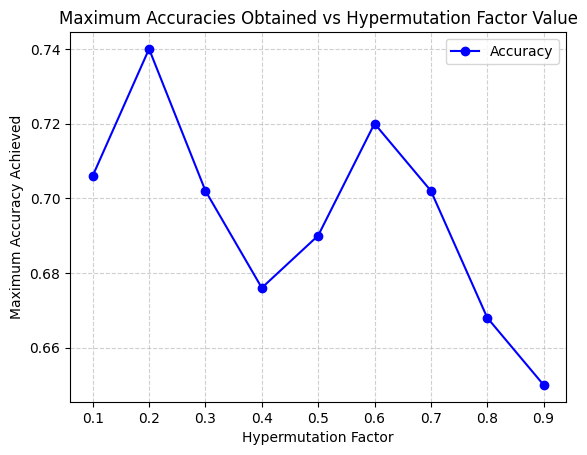

In [58]:
x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_values = max_accuracies

plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Hypermutation Factor')
plt.ylabel('Maximum Accuracy Achieved')
plt.title('Maximum Accuracies Obtained vs Hypermutation Factor Value')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## (Fitness Function only considers first 75 time samples)

In [59]:
def CSA_for_ECG_classification_two(iterations = 100, hypermutation_factor=0.1):
    training_data, testing_data, population, population_affinities = generate_initial_CSA_values_two()
    n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
    clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

    accuracies = []
    precisions = []
    recalls = []
    f_ones = []
    
    for i in range(iterations):
        hypermutated_clones = hypermutate_two(hypermutation_factor, clones)
        hypermutated_affinities = affinity_antibodies_two(hypermutated_clones, training_data.values.tolist())
        n_best_antibodies, n_best_affinities = n_best(hypermutated_clones, hypermutated_affinities)
        clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)
        
        accuracy, precision, recall, f1 = calculate_metrics(testing_data, clones)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f_ones.append(f1)

    iterations = list(range(1, len(accuracies) + 1))

    plt.figure(figsize=(10, 6))

    plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over 100 Iterations with Hypermutation Factor " + str(hypermutation_factor))

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("Maximum Accuracy Achieved: " + str(max(accuracies)))
    return max(accuracies)

In [60]:
max_accuracies_two = []

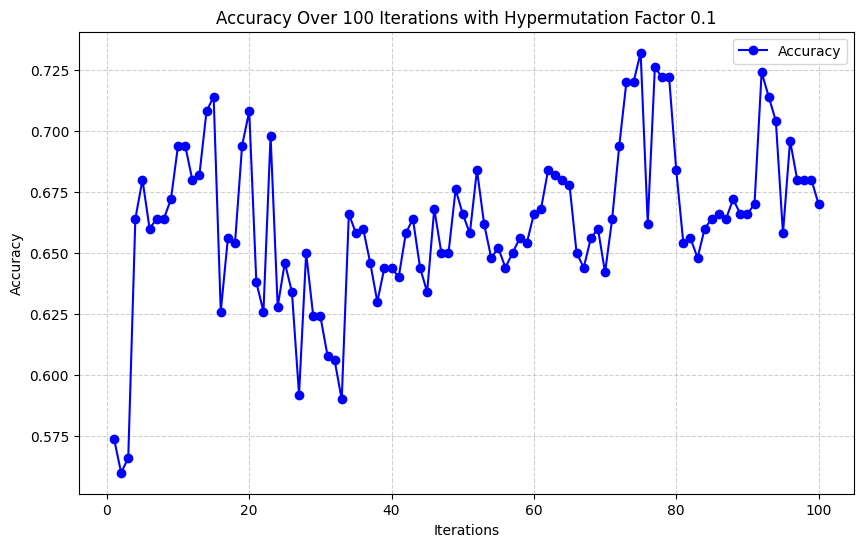

Maximum Accuracy Achieved: 0.732


In [61]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.1))

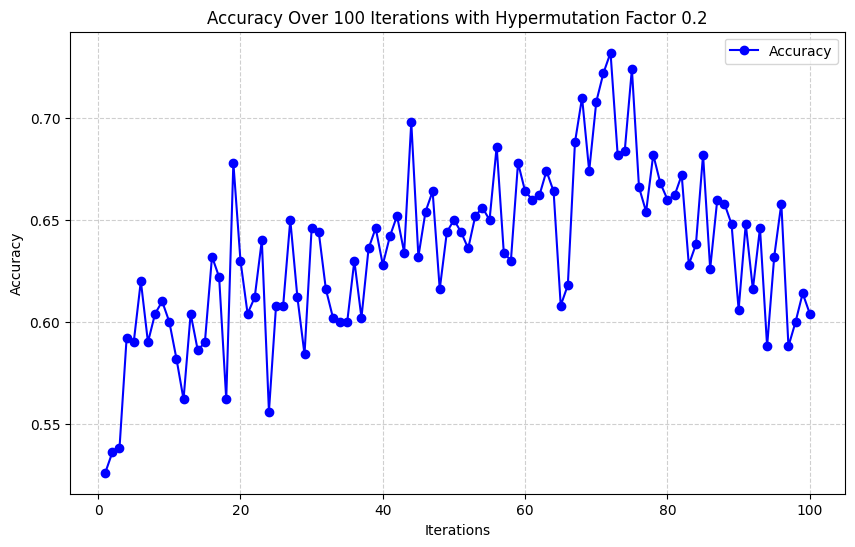

Maximum Accuracy Achieved: 0.732


In [62]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.2))

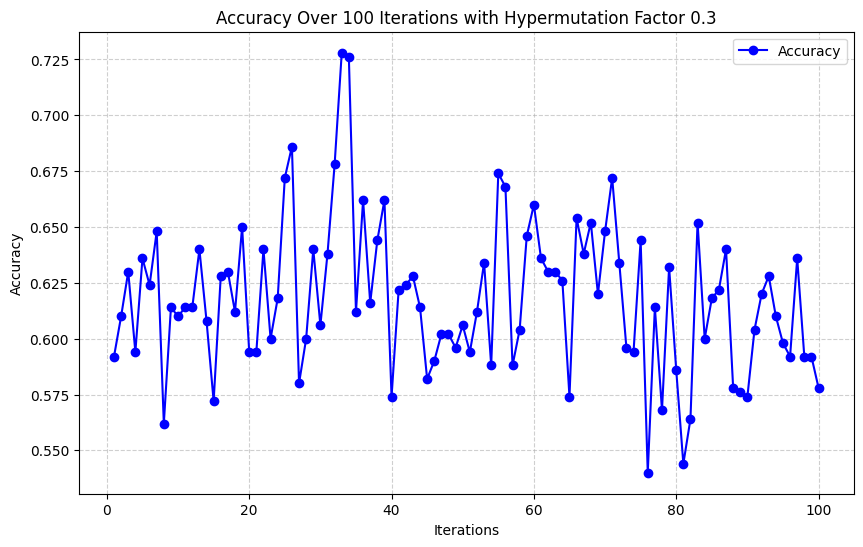

Maximum Accuracy Achieved: 0.728


In [63]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.3))

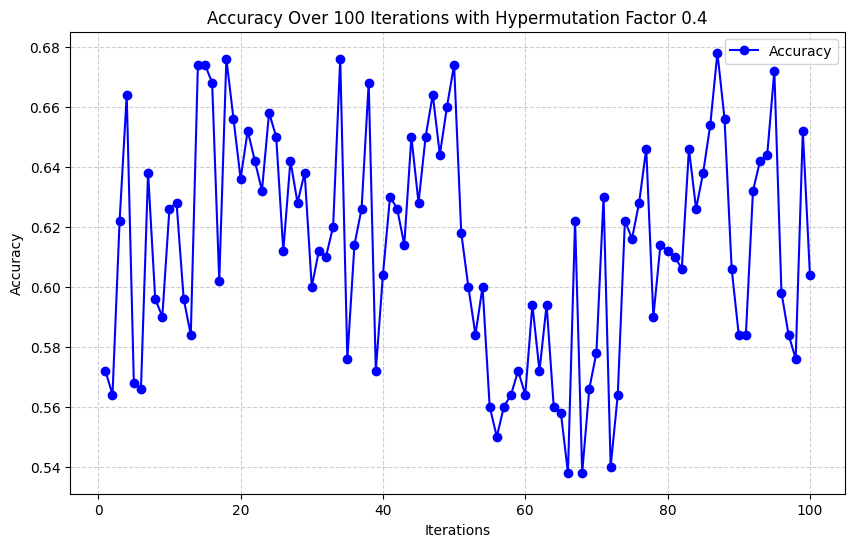

Maximum Accuracy Achieved: 0.678


In [64]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.4))

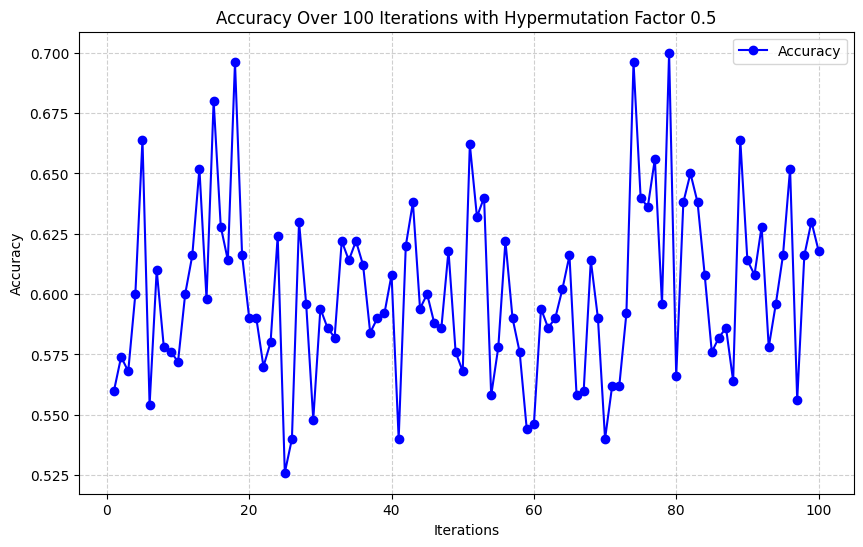

Maximum Accuracy Achieved: 0.7


In [65]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.5))

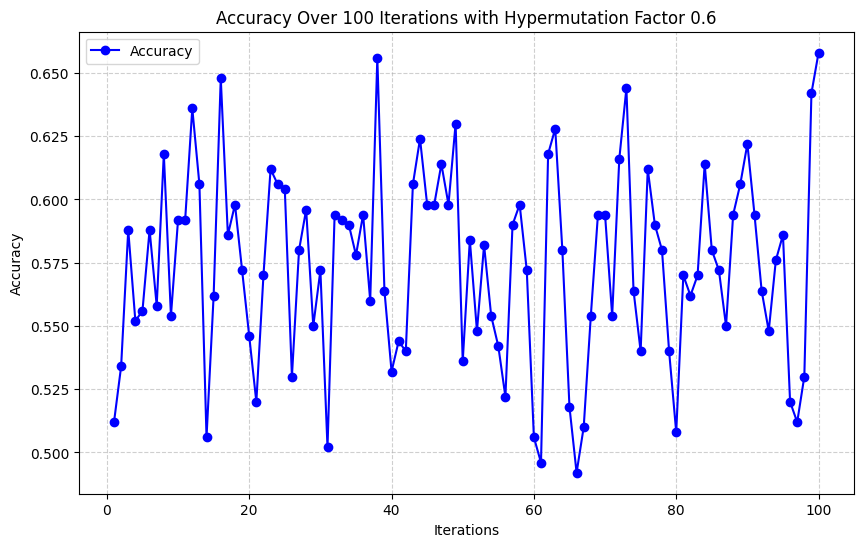

Maximum Accuracy Achieved: 0.658


In [66]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.6))

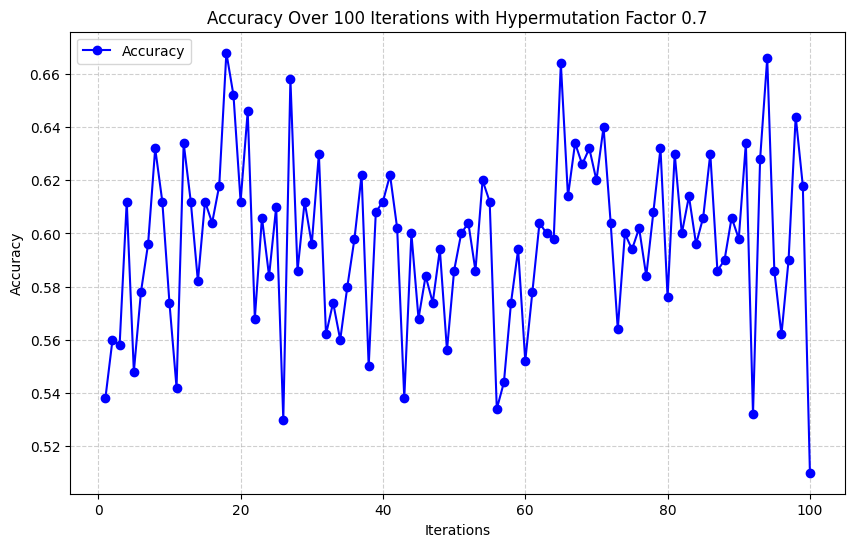

Maximum Accuracy Achieved: 0.668


In [67]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.7))

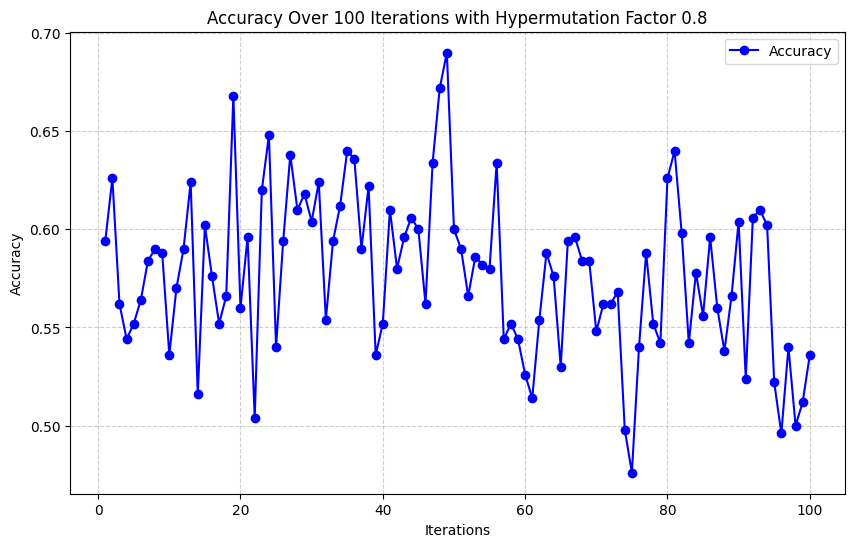

Maximum Accuracy Achieved: 0.69


In [68]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.8))

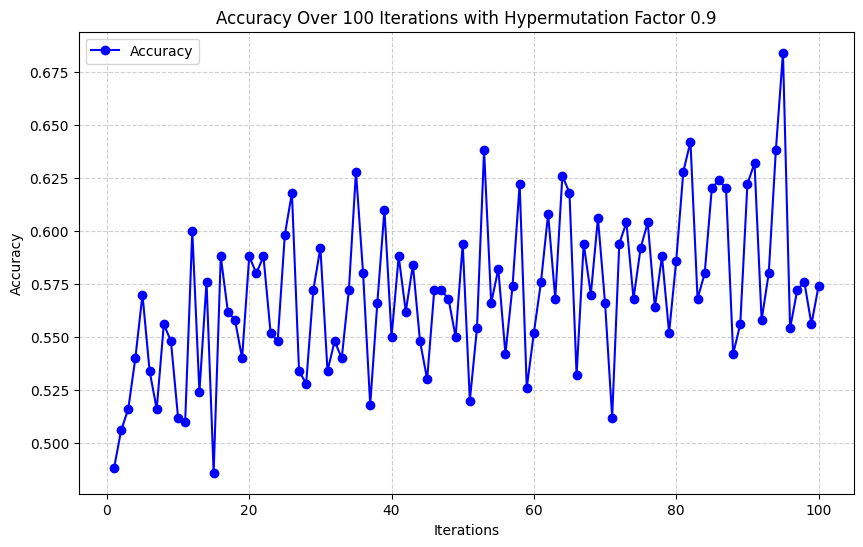

Maximum Accuracy Achieved: 0.684


In [69]:
max_accuracies_two.append(CSA_for_ECG_classification_two(hypermutation_factor=0.9))

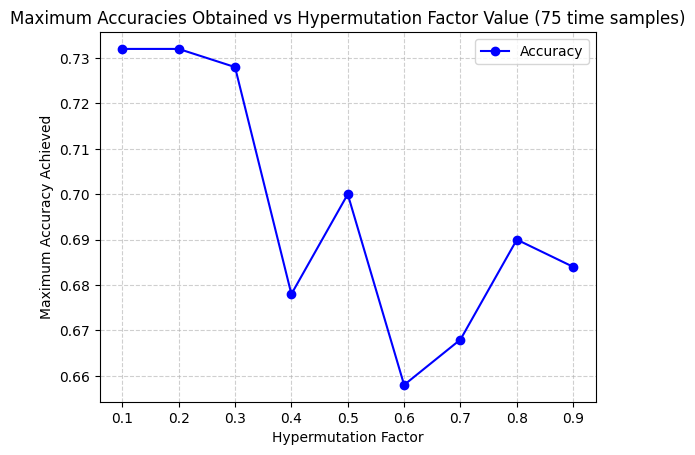

In [70]:
x_values_two = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_values_two = max_accuracies_two

plt.plot(x_values_two, y_values_two, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Hypermutation Factor')
plt.ylabel('Maximum Accuracy Achieved')
plt.title('Maximum Accuracies Obtained vs Hypermutation Factor Value (75 time samples)')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## (Fitness Function only considers first 100 samples)

In [71]:
def CSA_for_ECG_classification_three(iterations = 100, hypermutation_factor=0.1):
    training_data, testing_data, population, population_affinities = generate_initial_CSA_values_three()
    n_best_antibodies, n_best_affinities = n_best(population, population_affinities)
    clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)

    accuracies = []
    precisions = []
    recalls = []
    f_ones = []
    
    for i in range(iterations):
        hypermutated_clones = hypermutate_three(hypermutation_factor, clones)
        hypermutated_affinities = affinity_antibodies_three(hypermutated_clones, training_data.values.tolist())
        n_best_antibodies, n_best_affinities = n_best(hypermutated_clones, hypermutated_affinities)
        clones, clone_affinities = clone(cloning_factor, n_best_antibodies, n_best_affinities)
        
        accuracy, precision, recall, f1 = calculate_metrics(testing_data, clones)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f_ones.append(f1)

    iterations = list(range(1, len(accuracies) + 1))

    plt.figure(figsize=(10, 6))

    plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over 100 Iterations with Hypermutation Factor " + str(hypermutation_factor))

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("Maximum Accuracy Achieved: " + str(max(accuracies)))
    return max(accuracies)

In [72]:
max_accuracies_three = []

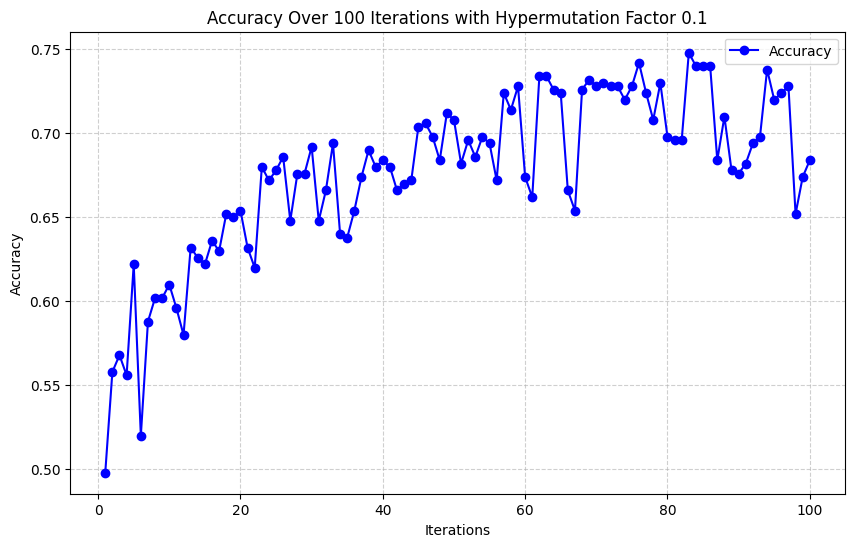

Maximum Accuracy Achieved: 0.748


In [73]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.1))

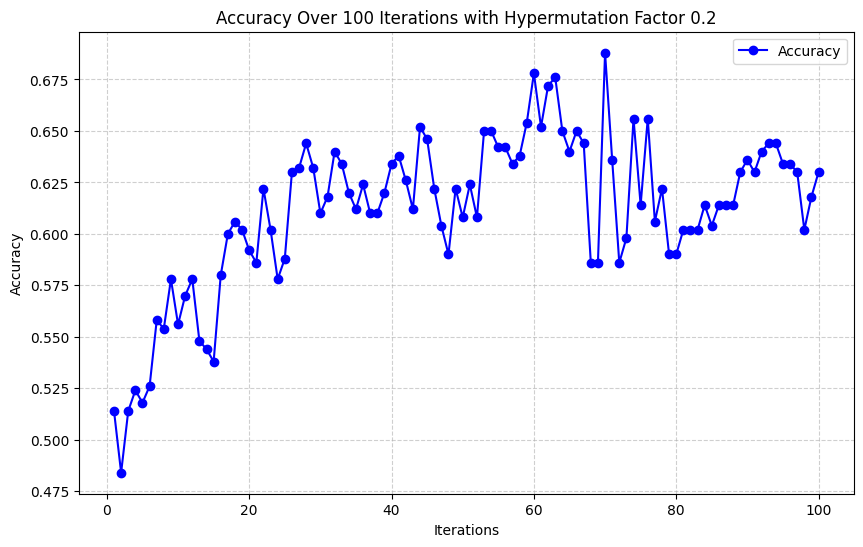

Maximum Accuracy Achieved: 0.688


In [74]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.2))

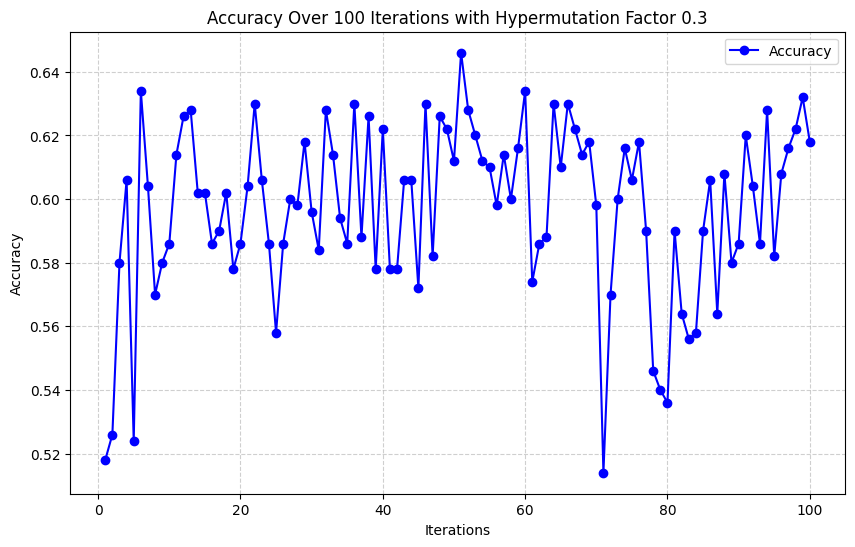

Maximum Accuracy Achieved: 0.646


In [75]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.3))

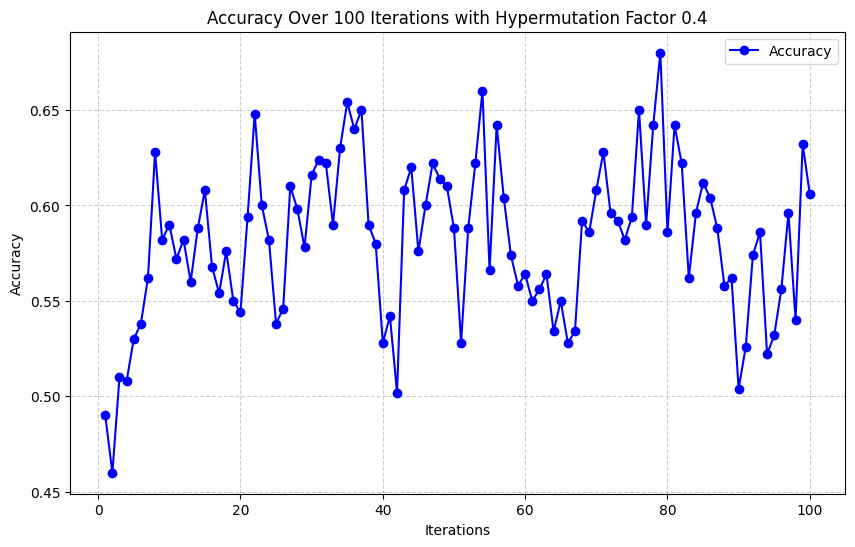

Maximum Accuracy Achieved: 0.68


In [76]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.4))

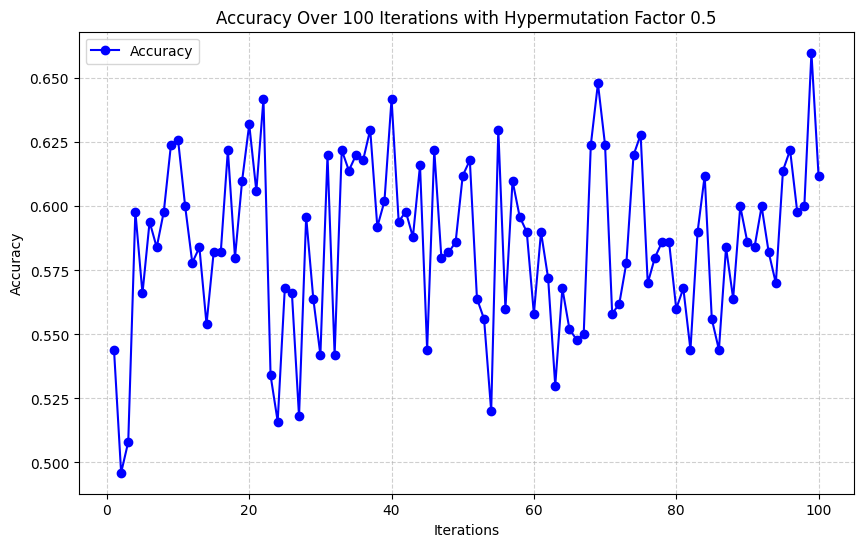

Maximum Accuracy Achieved: 0.66


In [77]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.5))

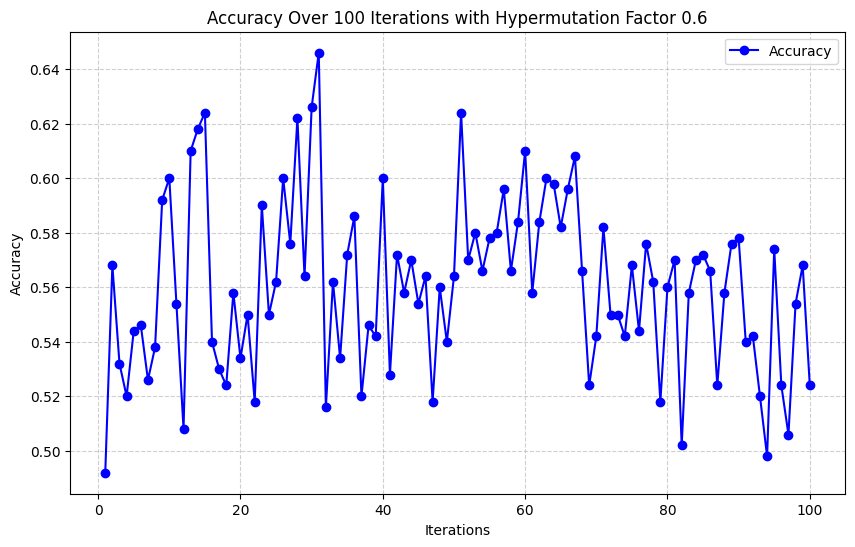

Maximum Accuracy Achieved: 0.646


In [78]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.6))

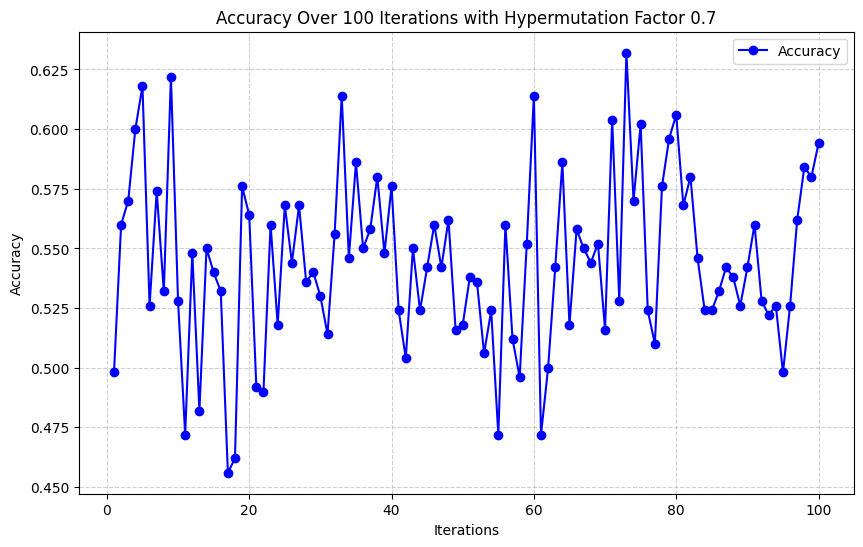

Maximum Accuracy Achieved: 0.632


In [79]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.7))

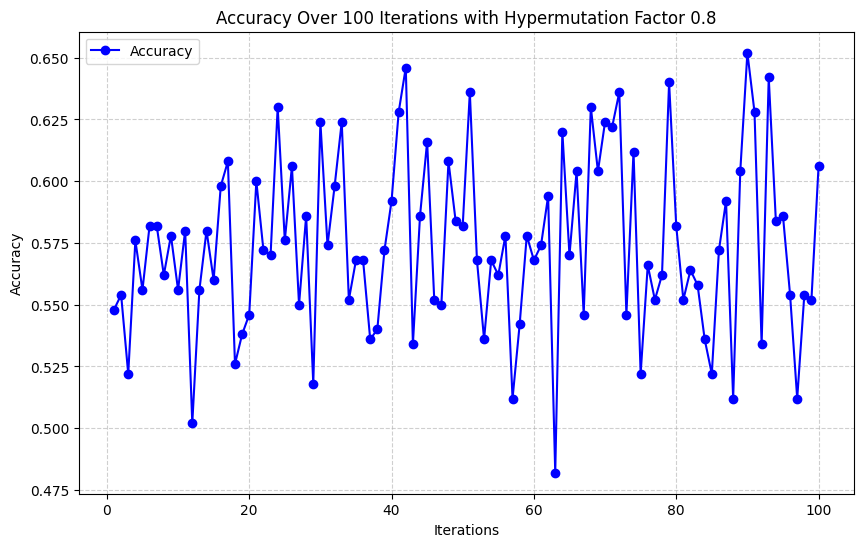

Maximum Accuracy Achieved: 0.652


In [80]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.8))

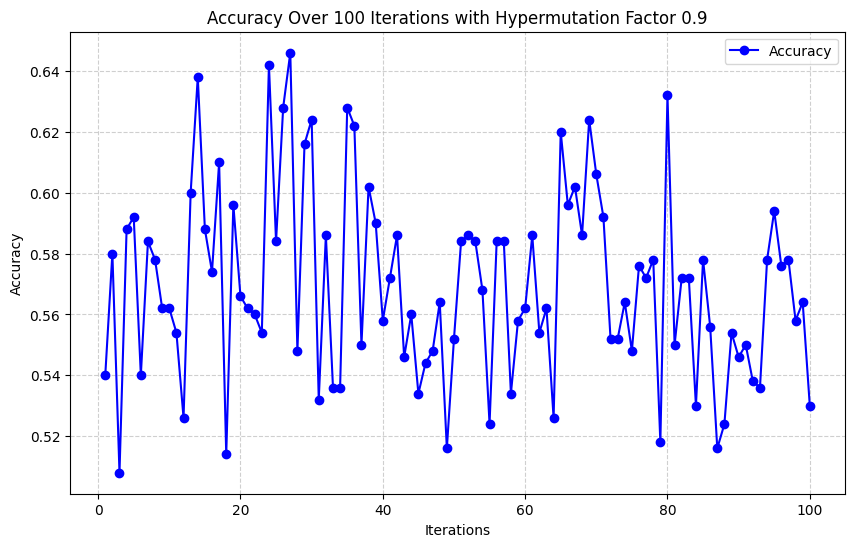

Maximum Accuracy Achieved: 0.646


In [81]:
max_accuracies_three.append(CSA_for_ECG_classification_three(hypermutation_factor=0.9))

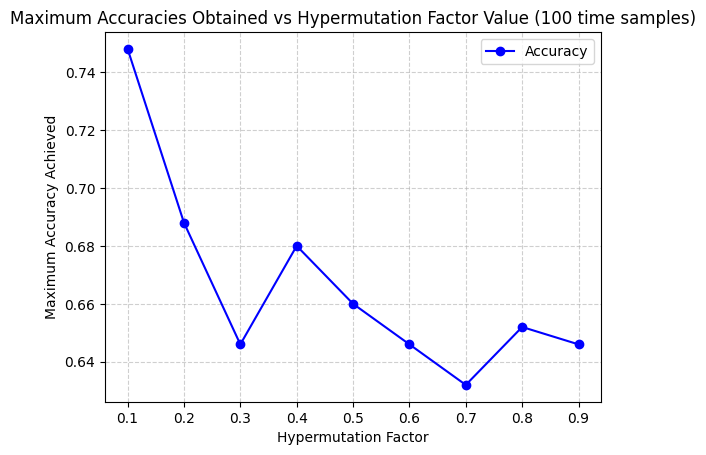

In [82]:
x_values_three = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_values_three = max_accuracies_three

plt.plot(x_values_three, y_values_three, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Hypermutation Factor')
plt.ylabel('Maximum Accuracy Achieved')
plt.title('Maximum Accuracies Obtained vs Hypermutation Factor Value (100 time samples)')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Comparing Maximum Accuracies Against Fitness Function

Text(0.5, 1.0, 'Maximum Accuracy vs. Fitness Function Label')

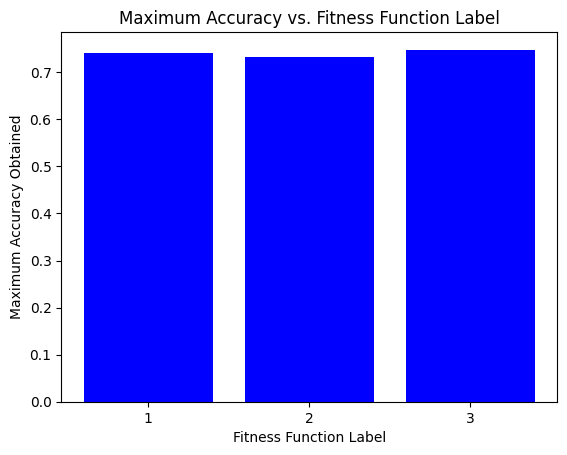

In [102]:
x_values = ['1', '2', '3']
y_values = [0.74, 0.732, 0.748]

plt.bar(x_values, y_values, color='b', label='Max Accuracy')
plt.xlabel('Fitness Function Label')
plt.ylabel('Maximum Accuracy Obtained')
plt.title('Maximum Accuracy vs. Fitness Function Label')

## Varying the Cloning Factor (Total 50 Clones to Total 200 Clones)

In [83]:
def CSA_with_varying_cloning_factors():
    cloning_factors = [40, 90, 140, 190]
    for cf in cloning_factors:
        cloning_factor = cf
        print("Cloning Factor: " + str(cloning_factor))
        CSA_for_ECG_classification(iterations = 100, hypermutation_factor=0.2)

Cloning Factor: 40


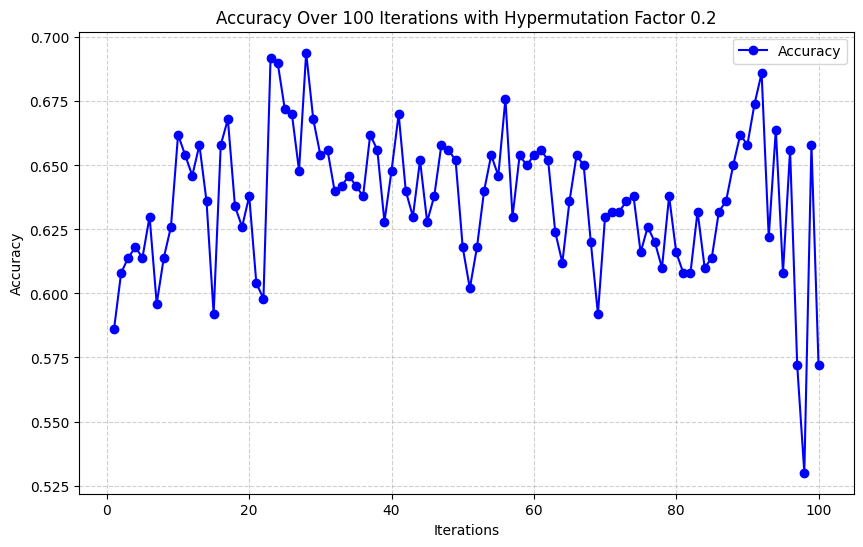

Maximum Accuracy Achieved: 0.694
Cloning Factor: 90


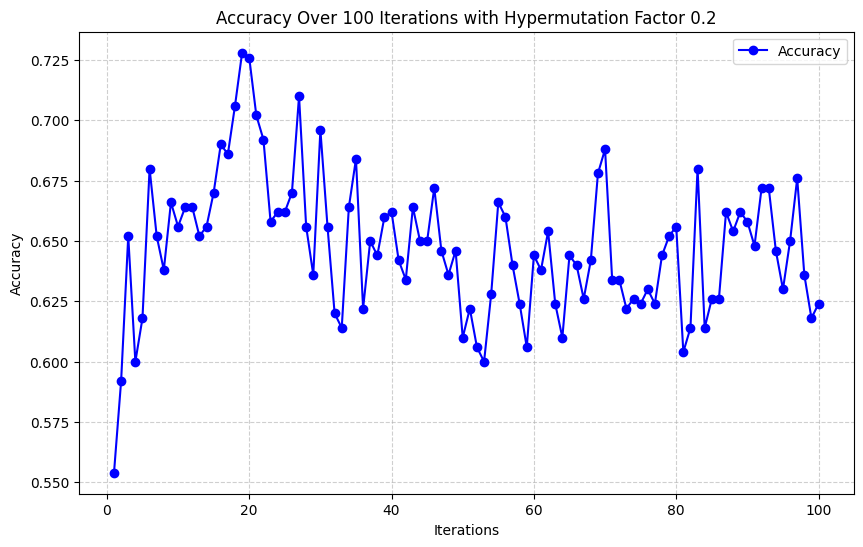

Maximum Accuracy Achieved: 0.728
Cloning Factor: 140


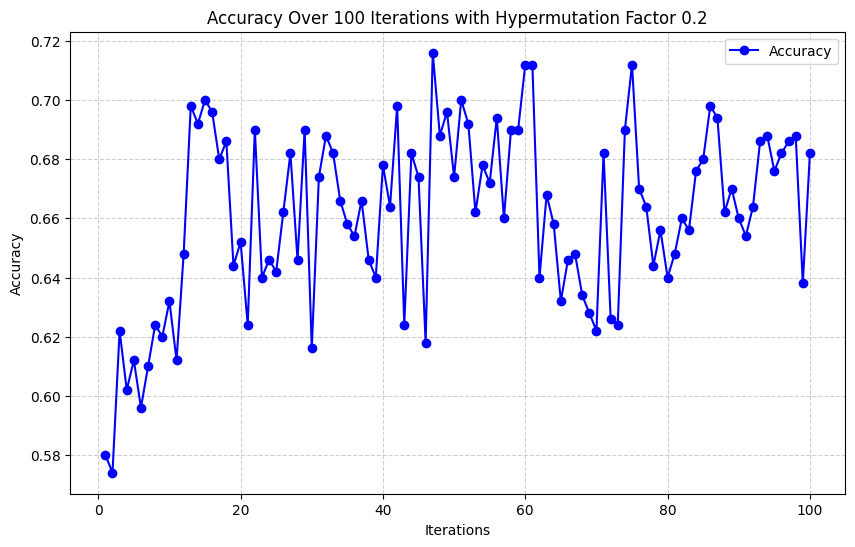

Maximum Accuracy Achieved: 0.716
Cloning Factor: 190


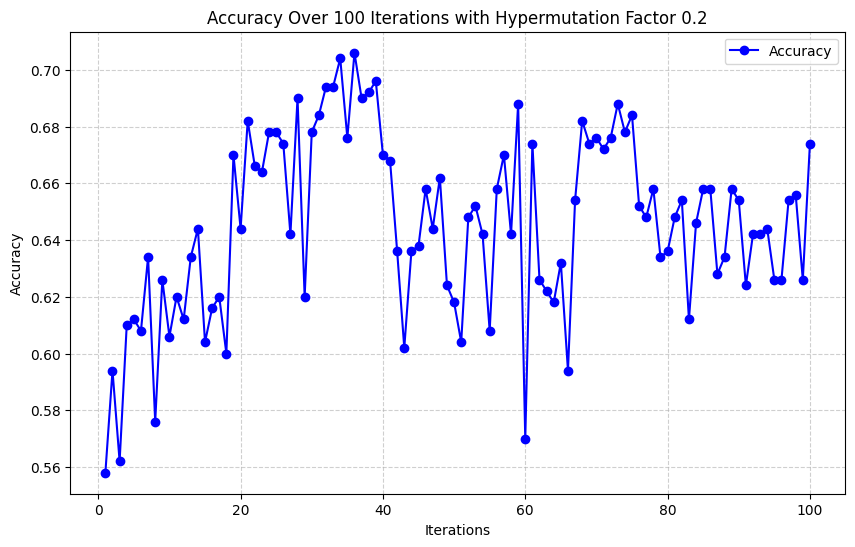

Maximum Accuracy Achieved: 0.706


In [93]:
CSA_with_varying_cloning_factors()

Text(0.5, 1.0, 'Maximum Accuracy vs. Cloning Factor')

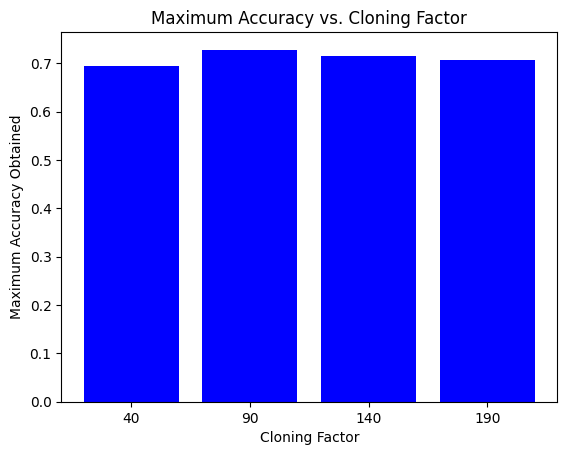

In [106]:
cloning_factors = ['40', '90', '140', '190']
cloning_factor_max_accuracies = [0.694, 0.728, 0.716, 0.706]

plt.bar(cloning_factors, cloning_factor_max_accuracies, color='b', label='Accuracy')
plt.xlabel('Cloning Factor')
plt.ylabel('Maximum Accuracy Obtained')
plt.title('Maximum Accuracy vs. Cloning Factor')

## Trying out different machine learning techniques

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [86]:
X = heartbeat_dataset.iloc[:, :-1]
y = heartbeat_dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression

In [87]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

C:\Users\varma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.8282

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.60      0.66       828
         1.0       0.85      0.92      0.88      2083

    accuracy                           0.83      2911
   macro avg       0.80      0.76      0.77      2911
weighted avg       0.82      0.83      0.82      2911


Logistic Regression Confusion Matrix:
[[ 494  334]
 [ 166 1917]]


### Support Vector Machine

In [89]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [90]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Accuracy: {accuracy_svm:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.8361

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68       828
         1.0       0.86      0.92      0.89      2083

    accuracy                           0.84      2911
   macro avg       0.81      0.77      0.79      2911
weighted avg       0.83      0.84      0.83      2911


SVM Confusion Matrix:
[[ 510  318]
 [ 159 1924]]


### Random Forest Classifier

In [91]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [92]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.9708

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       828
         1.0       0.97      0.99      0.98      2083

    accuracy                           0.97      2911
   macro avg       0.97      0.96      0.96      2911
weighted avg       0.97      0.97      0.97      2911


Random Forest Confusion Matrix:
[[ 771   57]
 [  28 2055]]


Text(0.5, 1.0, 'Accuracy vs. Classification Techniques')

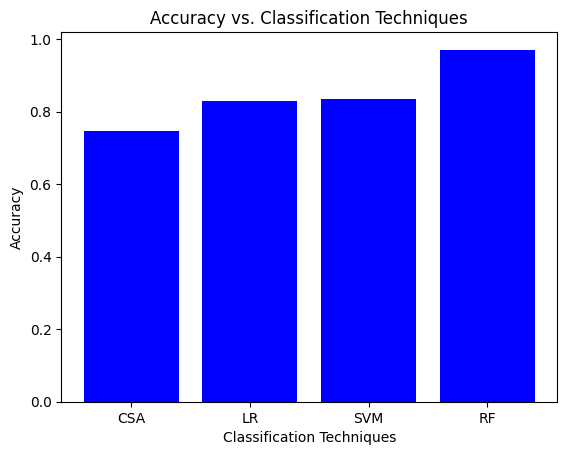

In [105]:
classification_techniques = ['CSA', 'LR', 'SVM', 'RF']
final_accuracies = [0.748, 0.8282, 0.8361, 0.9708]

plt.bar(classification_techniques, final_accuracies, color='b', label='Max Accuracy')
plt.xlabel('Classification Techniques')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Classification Techniques')